# Notebook Examples for Chapter 6
# Supervised Classification Part 1
Land cover classification of remote sensing imagery is an undertaking which
falls into the general category of _pattern recognition_.
Pattern recognition problems, in turn, are usually approached by developing
appropriate _machine learning_ algorithms.
Broadly speaking, machine learning involves tasks for which there
is no known direct, analytic method to compute a desired output from a set
of inputs. The strategy adopted is for the computer to learn
from a set of representative examples.
Chapter 6 focuses on the case of supervised classification, which can often be seen as the modeling of probability distributions of the training data. On the basis of
representative data for, say,   $K$ land cover classes presumed to be present in a scene, the _a posteriori_ probabilities for class $k$ conditional on observation $g$, namely $Pr(k\mid g)$, $k=1\dots K$, are _learned_ or approximated. This
is usually called the _training phase_ of the classification
procedure. Then these probabilities are used to classify all of
the pixels in the image, a step  referred to as the _generalization_ or _prediction_ phase.


## 6.1 Maximizing the _a posteriori_ probability
## 6.2 Training data separability

In [13]:
import ee
#ee.Authenticate()
ee.Initialize()

In [15]:
# first 5 principal components of ASTER image
image = ee.Image('projects/ee-mortcanty/assets/CRC5/AST_20070501_pca') \
                                      .select(0,1,2,3,4)
# training data
table = ee.FeatureCollection('projects/ee-mortcanty/assets/CRC5/train')
trainData = image.sampleRegions(table,['CLASS_ID'])
print(trainData.size().getInfo())

7173


In [16]:
def jmsep(class1, class2, image, table):
    # Jeffries-Matusita separability    
    table1 = table.filter(
        ee.Filter.eq('CLASS_ID',str(class1-1)))
    m1 = image.reduceRegion(ee.Reducer.mean(),table1)\
              .toArray() 
    s1 = image.toArray() \
         .reduceRegion(ee.Reducer.covariance(),table1)\
         .toArray()
    table2 = table.filter(
        ee.Filter.eq('CLASS_ID',str(class2-1)))
    m2 = image.reduceRegion(ee.Reducer.mean(),table2)\
              .toArray()
    s2 = image.toArray() \
        .reduceRegion(ee.Reducer.covariance(),table2,15)\
              .toArray()
    m12 = m1.subtract(m2)  
    m12 = ee.Array([m12.toList()]) # makes 2D matrix  
    s12i = s1.add(s2).divide(2).matrixInverse()
    # first term in Bhattacharyya distance
    B1 = m12.matrixMultiply(
          s12i.matrixMultiply(m12.matrixTranspose())) \
            .divide(8)
    ds1 = s1.matrixDeterminant()
    ds2 = s2.matrixDeterminant() 
    ds12 = s1.add(s2).matrixDeterminant()
    # second term
    B2 = ds12.divide(2).divide(ds1.multiply(ds2).sqrt())\
             .log().divide(2)
    B = ee.Number(B1.add(B2).project([0]).toList().get(0))
    # J-M separability
    return ee.Number(1).subtract(ee.Number(1) \
             .divide(B.exp())).multiply(2)

In [17]:
print(jmsep(7,8,image,table).getInfo())

1.9026665318307807


In [18]:
def band_mean(current,prev):
    current = ee.String(current)
    prev = ee.Dictionary(prev)
    trainData = ee.FeatureCollection(prev.get('trainData'))
    class_id = prev.get('class_id')
    means = ee.List(prev.get('means'))
    mu = trainData.filter(ee.Filter.eq('CLASS_ID',class_id)).aggregate_mean(current)
    return ee.Dictionary({ 'trainData':trainData,'class_id':class_id,'means':means.add(mu) })

def class_mean(trainData,class_id,bandNames):
    first = ee.Dictionary({'trainData':trainData,'class_id':str(class_id),'means':ee.List([])})
    return ee.Dictionary(bandNames.iterate(band_mean,first)).get('means')

mu = ee.Array(class_mean(trainData,7,image.bandNames()))
print(mu.getInfo())

[-28.38586464084563, -13.477546924748925, 0.23433266364269972, -0.40716485753027765, -0.2885723078052682]


### 6.3 Maximum likelihood classification

#### 6.3.1 Naive Bayes on the GEE

In [19]:
import geemap
# rename the class ids from strings to integers
trainData = image.sampleRegions(table,['CLASS_ID']) \
    .remap(['0','1','2','3','4','5','6','7','8','9'],
           [0,1,2,3,4,5,6,7,8,9],'CLASS_ID')
# train a naive Bayes classifier    
classifier = ee.Classifier.smileNaiveBayes()
trained = classifier\
    .train(trainData,'CLASS_ID',image.bandNames())
# classify the image and display    
classified = image.classify(trained)
map = geemap.Map()
map.centerObject(classified, 12)
map.addLayer(classified.byte(), {'min': 0.0, 'max': 10.0, 'palette': 'jet' }, 'Naive Bayes')
map

Map(center=[50.884108588959045, 6.426768742530182], controls=(WidgetControl(options=['position', 'transparent_…

#### 6.3.2 Scripts for supervised classification

In [1]:
%run scripts/classify -p [1,2,3,4,5] -a 1 imagery/AST_20070501_pca.tif imagery/train.shp

2024-08-14 19:37:47.324985: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-14 19:37:47.325354: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-14 19:37:47.327413: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-14 19:37:47.356028: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 19:37:47.946824: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Training with MaxLike
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 0.0015065670013427734
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 1.051891565322876
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_MaxLike.tst
done


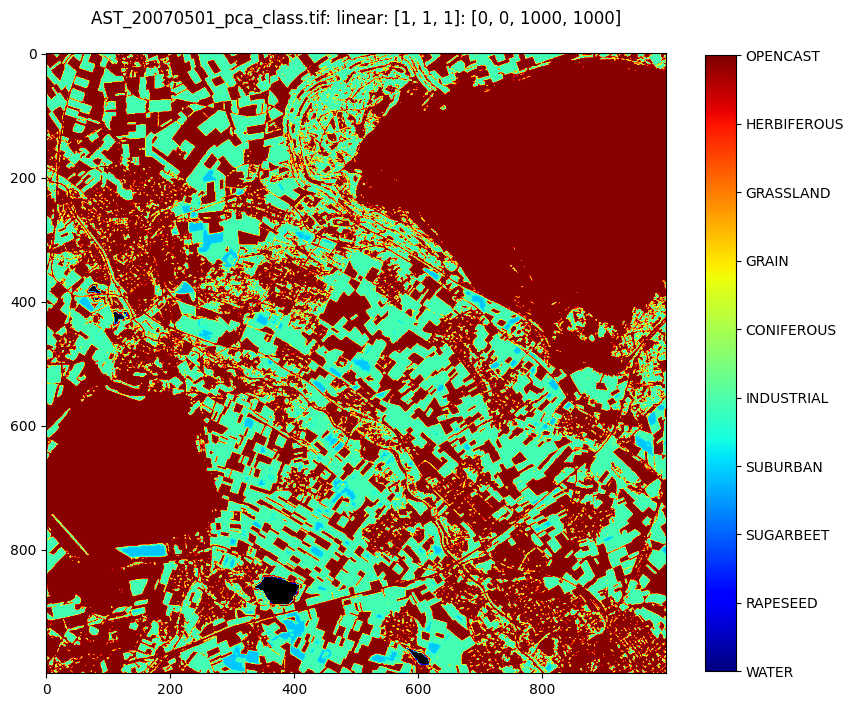

In [2]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c \
-r  "['WATER', 'RAPESEED', 'SUGARBEET', 'SUBURBAN', 'INDUSTRIAL', 'CONIFEROUS', 'GRAIN', 'GRASSLAND', 'HERBIFEROUS', 'OPENCAST']" \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter6/fig6_5.eps'

### 6.4 Gaussian kernel classification

In [1]:
%run scripts/classify -p [1,2,3,4,5] -a 2 -P imagery/AST_20070501_pca.tif imagery/train.shp

2024-08-14 19:46:28.917249: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-14 19:46:28.917683: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-14 19:46:28.920001: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-14 19:46:28.950958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 19:46:29.581986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Training with Gausskernel
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']


/home/mort/python/CRC5Docker/src/auxil/supervisedclass.py:98: RuntimeWarning: invalid value encountered in divide
  return pvs/s


sigma: 0.001000  error: 0.354106
sigma: 0.100000  error: 0.050021
sigma: 1.000000  error: 0.194248
sigma: 0.443769  error: 0.129012
sigma: 0.231308  error: 0.099625
sigma: 0.150155  error: 0.070238
sigma: 0.062185  error: 0.034806
sigma: 0.038815  error: 0.027928
sigma: 0.024371  error: 0.025010
sigma: 0.015444  error: 0.025010
sigma: 0.019907  error: 0.024802
sigma: 0.019927  error: 0.024802
sigma: 0.019947  error: 0.024802
sigma: 0.021637  error: 0.025010
sigma: 0.020593  error: 0.025010
sigma: 0.020194  error: 0.024802
sigma: 0.020346  error: 0.024802
sigma: 0.020440  error: 0.024802
sigma: 0.020498  error: 0.025010
sigma: 0.020404  error: 0.024802
sigma: 0.020382  error: 0.024802
elapsed time 26.40139603614807
classifying...
row: 0


/home/mort/python/CRC5Docker/src/scripts/classify.py:238: RuntimeWarning: invalid value encountered in cast
  Ms = np.byte(Ms*255)


row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 361.4562931060791
class probabilities written to: imagery/AST_20070501_pca_classprobs.tif
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_Gausskernel.tst
done


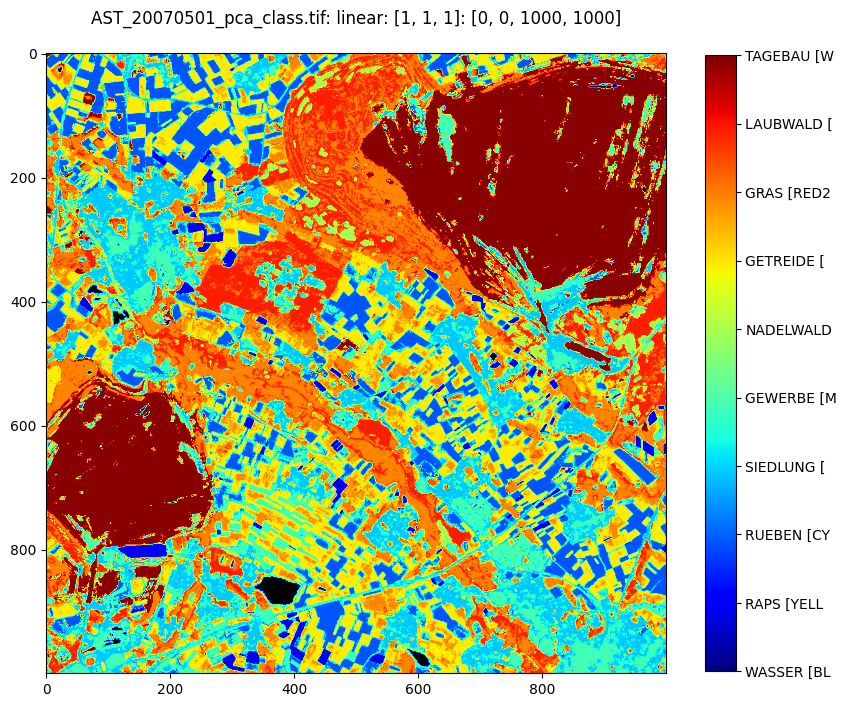

In [2]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c \
-r "['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']" \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter6/fig6_6.eps'

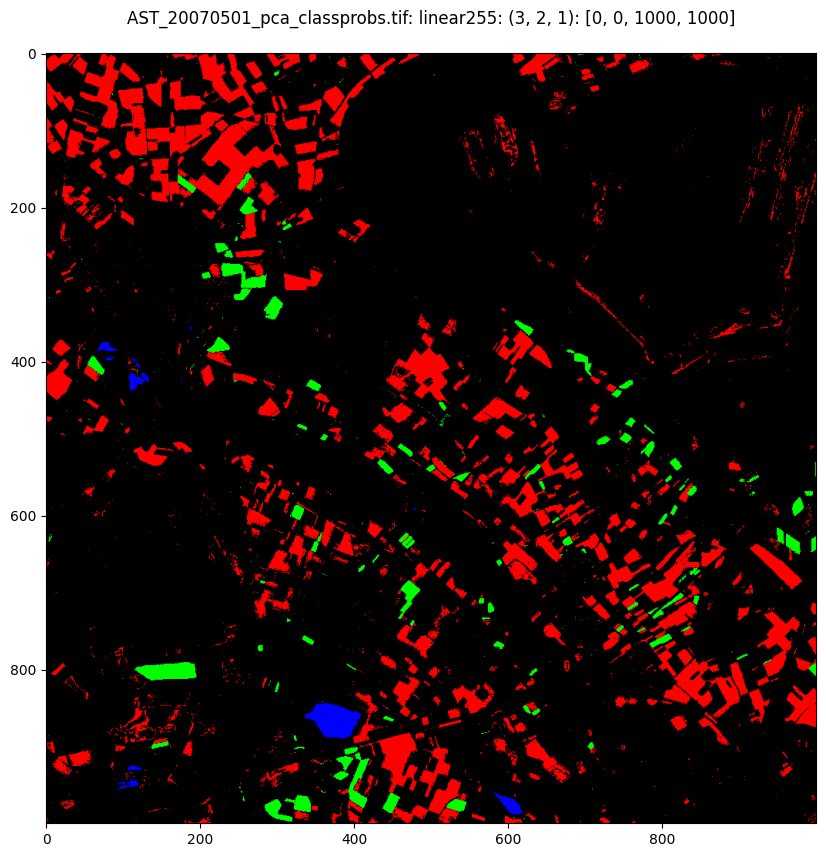

In [3]:
%run scripts/dispms -f imagery/AST_20070501_pca_classprobs.tif -p [3,2,1] -e 1 \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter6/fig6_7.eps'

## 6.5 Neural networks
### 6.5.1 The neural network classifier
### 6.5.2 Cost functions
### 6.5.3 Backpropagation

Training with NNet(Backprop)
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 494.99302887916565
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 0.3617570400238037
thematic map written to: imagery/AST_20070501_pca_class.tif


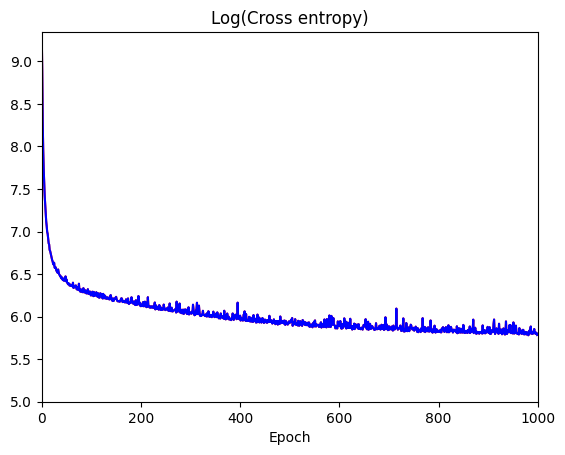

test results written to: imagery/AST_20070501_pca_NNet(Backprop).tst
done


In [4]:
%run scripts/classify -p [1,2,3,4,5] -a 3 -e 1000 -L [10] imagery/AST_20070501_pca.tif imagery/train.shp

Training with NNet(Congrad)
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 5.240119457244873
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 0.3498210906982422
class probabilities written to: imagery/AST_20070501_pca_classprobs.tif
thematic map written to: imagery/AST_20070501_pca_class.tif


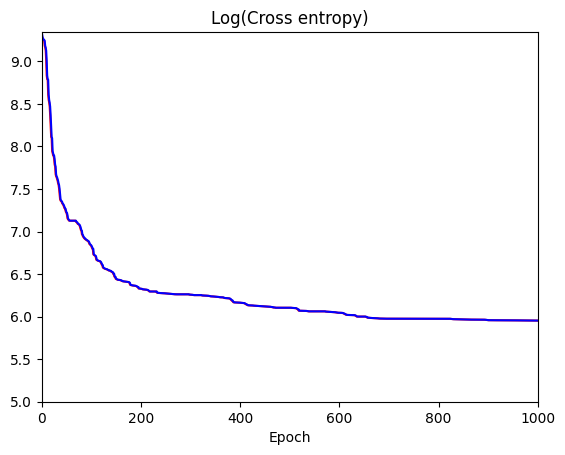

test results written to: imagery/AST_20070501_pca_NNet(Congrad).tst
done


In [5]:
%run scripts/classify -p [1,2,3,4,5] -P -a 4 -e 1000 -L [10] imagery/AST_20070501_pca.tif imagery/train.shp

Training with NNet(Kalman)
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 33.43261647224426
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 0.33532238006591797
thematic map written to: imagery/AST_20070501_pca_class.tif


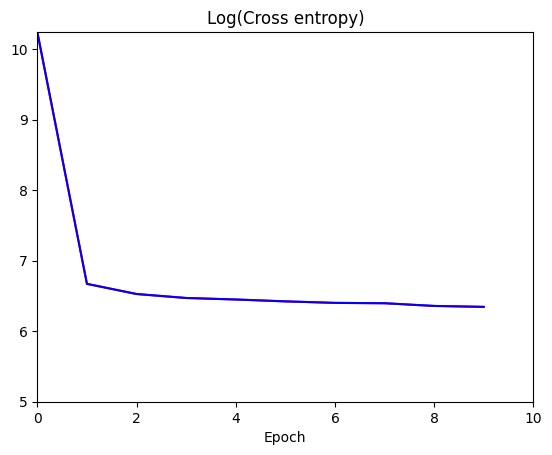

test results written to: imagery/AST_20070501_pca_NNet(Kalman).tst
done


In [6]:
run scripts/classify -p [1,2,3,4,5] -a 5 -e 10 -L [10] imagery/AST_20070501_pca.tif imagery/train.shp

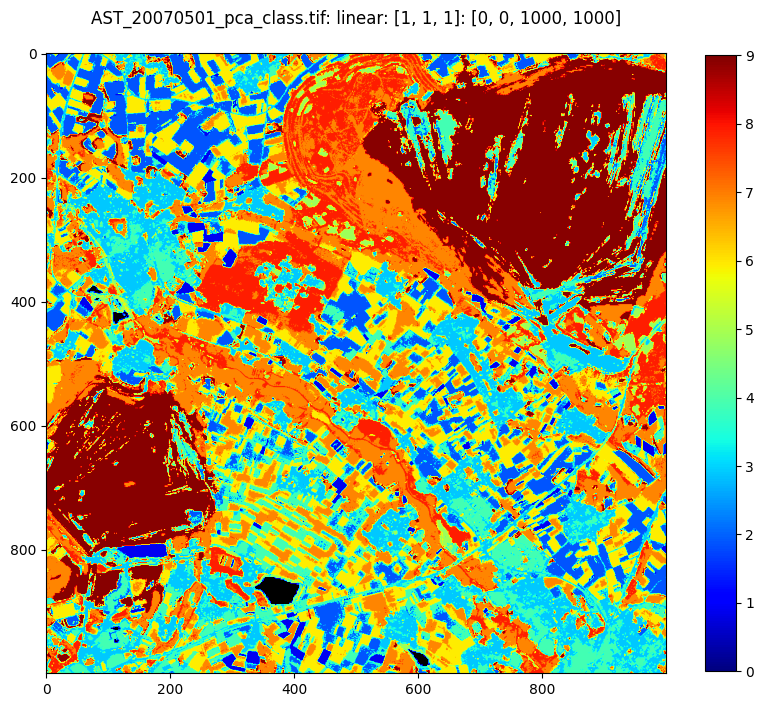

In [7]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif  -c

### 6.5.4 Deep learning networks

In [8]:
run scripts/classify -p [1,2,3,4,5] -a 6 -e 1000 -L [10,10,10] imagery/AST_20070501_pca.tif imagery/train.shp

Training with Dnn(tensorflow)
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 189.92965698242188
classifying...
row: 0
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 575us/step
row: 100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 585us/step
row: 200
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 603us/step
row: 300
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 580us/step
row: 400
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 603us/step
row: 500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 629us/step
row: 600
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 589us/step
row: 700
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 595us/step
row: 800
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 596us/step
row: 900
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 592us/step
elapsed time 18.878464698791504
thematic map written to: imagery/AST_20070501_pca_class.tif
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
test results written to: imagery/AST_20070501_pca_Dnn(tensorflow).tst
done


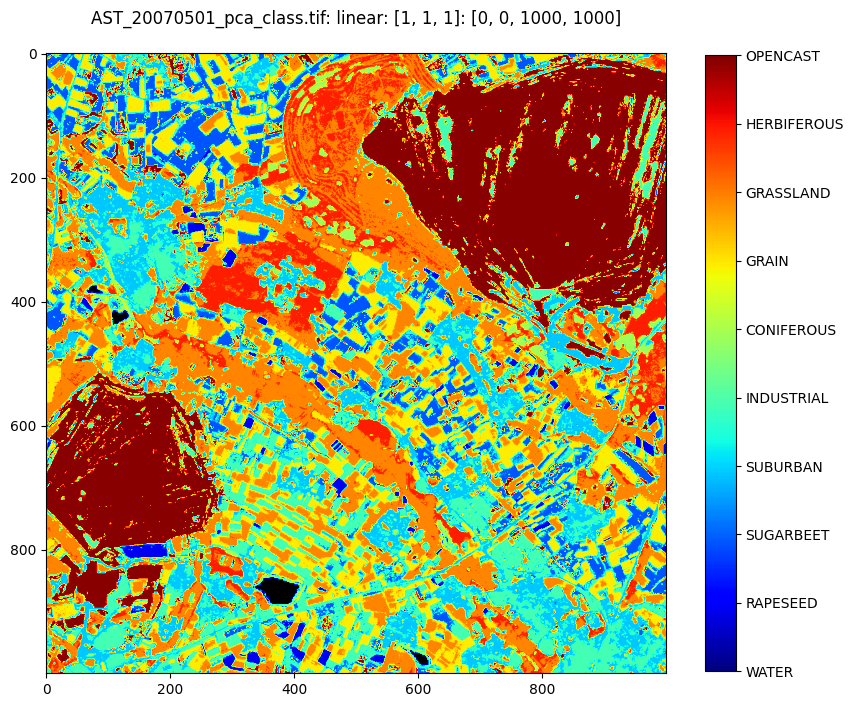

In [9]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c \
-r  "['WATER', 'RAPESEED', 'SUGARBEET', 'SUBURBAN', 'INDUSTRIAL', 'CONIFEROUS', 'GRAIN', 'GRASSLAND', 'HERBIFEROUS', 'OPENCAST']"

## 6.6 Support Vector Machines
### 6.6.1 Linearly separable classes
### 6.6.2 Overlapping classes
### 6.6.3 Solution with sequential minimal optimization
### 6.6.4 Multi class SVMs
### 6.6.5 Kernel substitution

In [10]:
run scripts/classify -p [1,2,3,4,5] -a 7 -P imagery/AST_20070501_pca.tif imagery/train.shp

Training with SVM
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 0.2415163516998291
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 68.61632442474365
class probabilities written to: imagery/AST_20070501_pca_classprobs.tif
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_SVM.tst
done


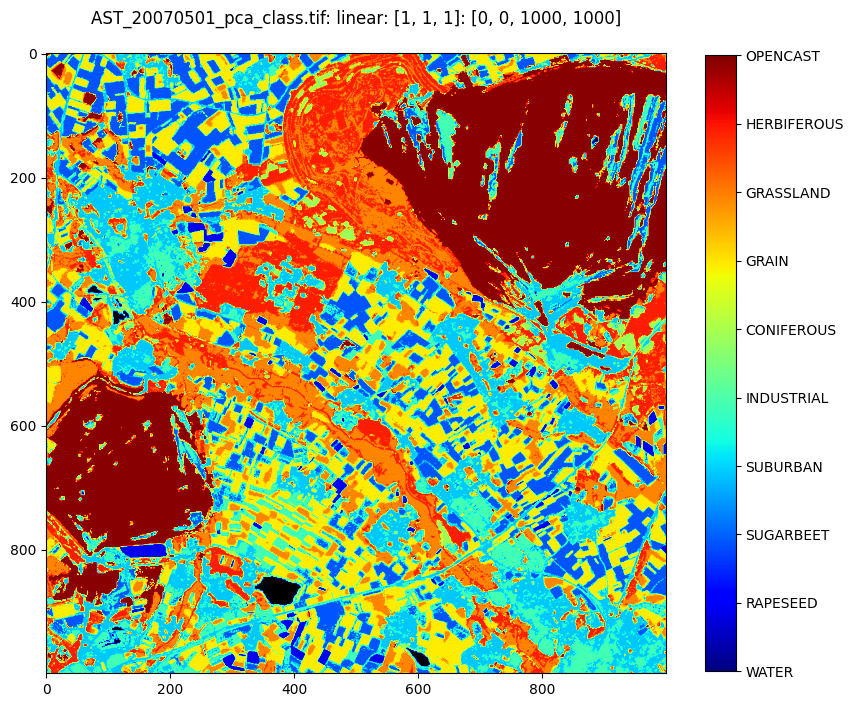

In [11]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c\
-r  "['WATER', 'RAPESEED', 'SUGARBEET', 'SUBURBAN', 'INDUSTRIAL', 'CONIFEROUS', 'GRAIN', 'GRASSLAND', 'HERBIFEROUS', 'OPENCAST']" \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter6/fig6_19.eps'

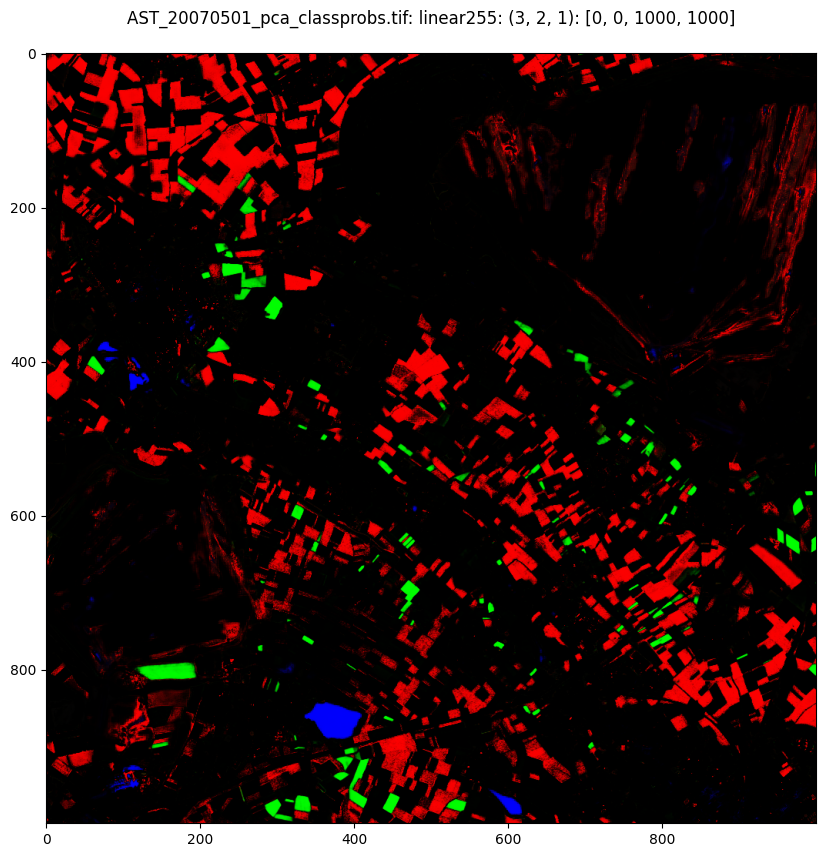

In [12]:
%run scripts/dispms -f imagery/AST_20070501_pca_classprobs.tif -p [3,2,1] -e 1

In [20]:
# train a SVM classifier  
import geemap
classifier = ee.Classifier.libsvm(kernelType='RBF'
                                ,gamma=0.1,cost=10)
trainData = image.sampleRegions(table,['CLASS_ID']) \
    .remap(['0','1','2','3','4','5','6','7','8','9'],
           [0,1,2,3,4,5,6,7,8,9],'CLASS_ID')
trained = classifier.\
    train(trainData,'CLASS_ID',image.bandNames())
# classify the image and display    
classified = image.classify(trained)
map = geemap.Map()
map.centerObject(classified, 12)
map.addLayer(classified.byte(), {'min': 0.0, 'max': 10.0, 'palette': 'jet'}, 'SVM')
map

Map(center=[50.884108588959045, 6.426768742530182], controls=(WidgetControl(options=['position', 'transparent_…